In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline
pd.set_option('max_columns', None)

In [177]:
df_original = pd.read_csv('../Data/boston_listings.csv')
df = pd.read_csv('../Data/boston_listings_updated.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head(2)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,...,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed,flexible,moderate,strict,super_strict_30
0,735703,0.0,0.0,0.0,False,1,True,False,42.282619,-71.133068,...,0,0,0,0,0,1,0,1,0,0
1,734661,1.0,1.0,1.0,False,1,True,True,42.286241,-71.134374,...,0,0,0,0,0,1,0,1,0,0


Let's have a look at our target variable 'price'.

count    3585.000000
mean      173.925802
std       148.331321
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64


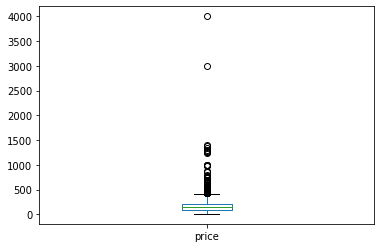

In [3]:
print(df['price'].describe()) 
df['price'].plot(kind ='box')

We have some outliers in the data and some extreme values as well. <br>
Let's use _Tukey rule_ to detect the outliers.

In [4]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)

IQR = Q3 -Q1

Max = Q3 + 1.5*IQR
Min = Q1 - 1.5*IQR
print('Min value {} , Max value {}'.format(Min,Max))

Min value -117.5 , Max value 422.5


So, we have outliers at higher price values but non for lower(negative min value). <br>
Let's see the count for outliers for values higher than 422.

In [5]:
print('Total count for price higher than 422 = ' + str(df[df['price'] > 422]['price'].count()))
print('A look at the outlier prices :' + str(np.sort(df[df['price'] > 422]['price'].unique())))

Total count for price higher than 422 = 124
A look at the outlier prices :[ 425  429  449  450  451  459  464  479  480  499  500  506  524  525
  536  550  559  568  570  575  599  600  603  625  650  680  690  695
  699  700  725  750  769  800  849  872  975  999 1000 1235 1250 1275
 1300 1345 1372 1400 3000 4000]


We have a lot of values at range below 422, lets take upper limit to 500. 

In [6]:
df = df.query('price < 500')

## Prediction

We will use **pycaret** library for our prediction

In [7]:
import pycaret
from pycaret.regression import *

Initializing the environment in pycaret. Creating the transformation pipeline to prepare the data for modeling and deployment.

In [8]:
bnb_setup = setup(df, target='price')

 
Setup Succesfully Completed!


,Description,Value
0,session_id,2160
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(3495, 135)"
4,Missing Values,False
5,Numeric Features,29
6,Categorical Features,105
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Comparing all models in the model library and score them using K-fold Cross Validation

In [9]:
compare_models(fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,32.085200,2104.351100,45.827500,0.742800,0.284900,0.235700
1,Light Gradient Boosting Machine,32.809900,2226.880800,47.161200,0.727100,0.294100,0.239600
2,Random Forest,33.556400,2347.818500,48.417100,0.713400,0.298400,0.247900
3,Gradient Boosting Regressor,34.873500,2408.985300,49.063600,0.705900,0.306800,0.260700
4,Extreme Gradient Boosting,34.992300,2417.168900,49.139000,0.704900,0.307700,0.261300
5,Extra Trees Regressor,33.820000,2447.305500,49.448200,0.701300,0.312100,0.251400
6,Bayesian Ridge,37.412500,2575.676700,50.722800,0.685400,0.363200,0.288600
7,Ridge Regression,37.588600,2579.232900,50.748700,0.685000,0.374700,0.291500
8,Linear Regression,37.793400,2604.039200,50.983100,0.682000,0.379500,0.293900
9,Random Sample Consensus,37.462700,2704.041900,51.963600,0.670000,0.376900,0.278400


We have selected highest scoring model for perdiction. 

In [10]:
catboost_regressor = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,32.5572,2042.5096,45.1941,0.7428,0.2762,0.2290
1,30.0468,1778.9074,42.1771,0.7453,0.2551,0.2039
2,33.5046,2113.4560,45.9723,0.7141,0.3009,0.2486
3,33.8937,2459.2462,49.5908,0.7437,0.3112,0.2623
4,33.2512,2214.5067,47.0585,0.7500,0.3074,0.2474
5,31.3306,2127.9391,46.1296,0.7466,0.2775,0.2312
6,34.2582,2632.9892,51.3127,0.6877,0.3061,0.2485
7,29.9804,1713.2332,41.3912,0.7493,0.2653,0.2238
8,29.9278,1781.2168,42.2045,0.7835,0.2738,0.2211
9,29.9728,2028.4154,45.0379,0.7850,0.2593,0.2095


Let's tune the model to get the best hyperparameters and select the best model based on Mean Square Error.

In [11]:
tuned_catboost_regressor = tune_model('catboost',optimize ='mse')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,32.7485,2121.7688,46.0627,0.7328,0.2844,0.2287
1,30.3737,1846.5233,42.9712,0.7356,0.2562,0.2062
2,33.0600,2100.6061,45.8324,0.7158,0.3033,0.2494
3,32.7479,2373.4893,48.7185,0.7527,0.3003,0.2466
4,32.9815,2308.1585,48.0433,0.7395,0.3131,0.2481
5,30.9682,2103.6529,45.8656,0.7495,0.2809,0.2284
6,34.2611,2668.3981,51.6565,0.6835,0.3163,0.2512
7,29.1743,1701.5870,41.2503,0.7510,0.2596,0.2117
8,29.5289,1752.9477,41.8682,0.7870,0.2779,0.2198
9,29.6691,2022.6446,44.9738,0.7856,0.2653,0.2046


In [12]:
predictions = predict_model(tuned_catboost_regressor)

final_model = finalize_model(tuned_catboost_regressor)
final_model.get_params()

{'iterations': 1000,
 'learning_rate': 0.1,
 'depth': 7,
 'l2_leaf_reg': 5,
 'loss_function': 'RMSE',
 'border_count': 100,
 'silent': True,
 'random_state': 2160}

Our RMSE for final model is 41.25 dollars, meaning that our regressor is wrong by that much on average.
<br><br>
But our motive here is to understand important variables that contribute towards price of the AirBnB. 

Save the model for further use.

In [ ]:
save_model(final_model, 'airbnb_catboost_1')

Let's plot interpretation of the model based on the SHAP (SHapley Additive exPlanations), which is a unified approach to explain the output of the machine learning model. 

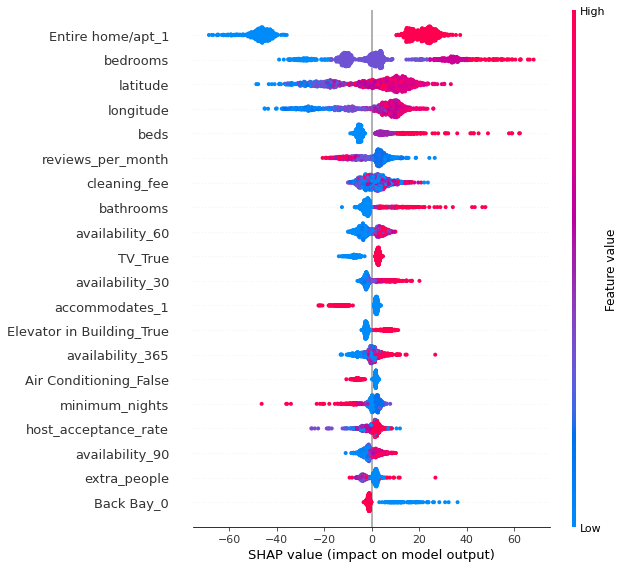

In [14]:
interpret_model(final_model)

Importnave of feature for pred

In [135]:
features = final_model.get_feature_importance(prettified = True).set_index('Feature Id').to_dict()['Importances']

#sort by decreasing importance 
feature_importance_dict = dict([(v[0],v[1]) for v in sorted(features1.items(), key=lambda kv: (-kv[1], kv[0]))])

Let's check the significance of annementies in price of the AirBnB.

Text(0, 0.5, 'Importance')

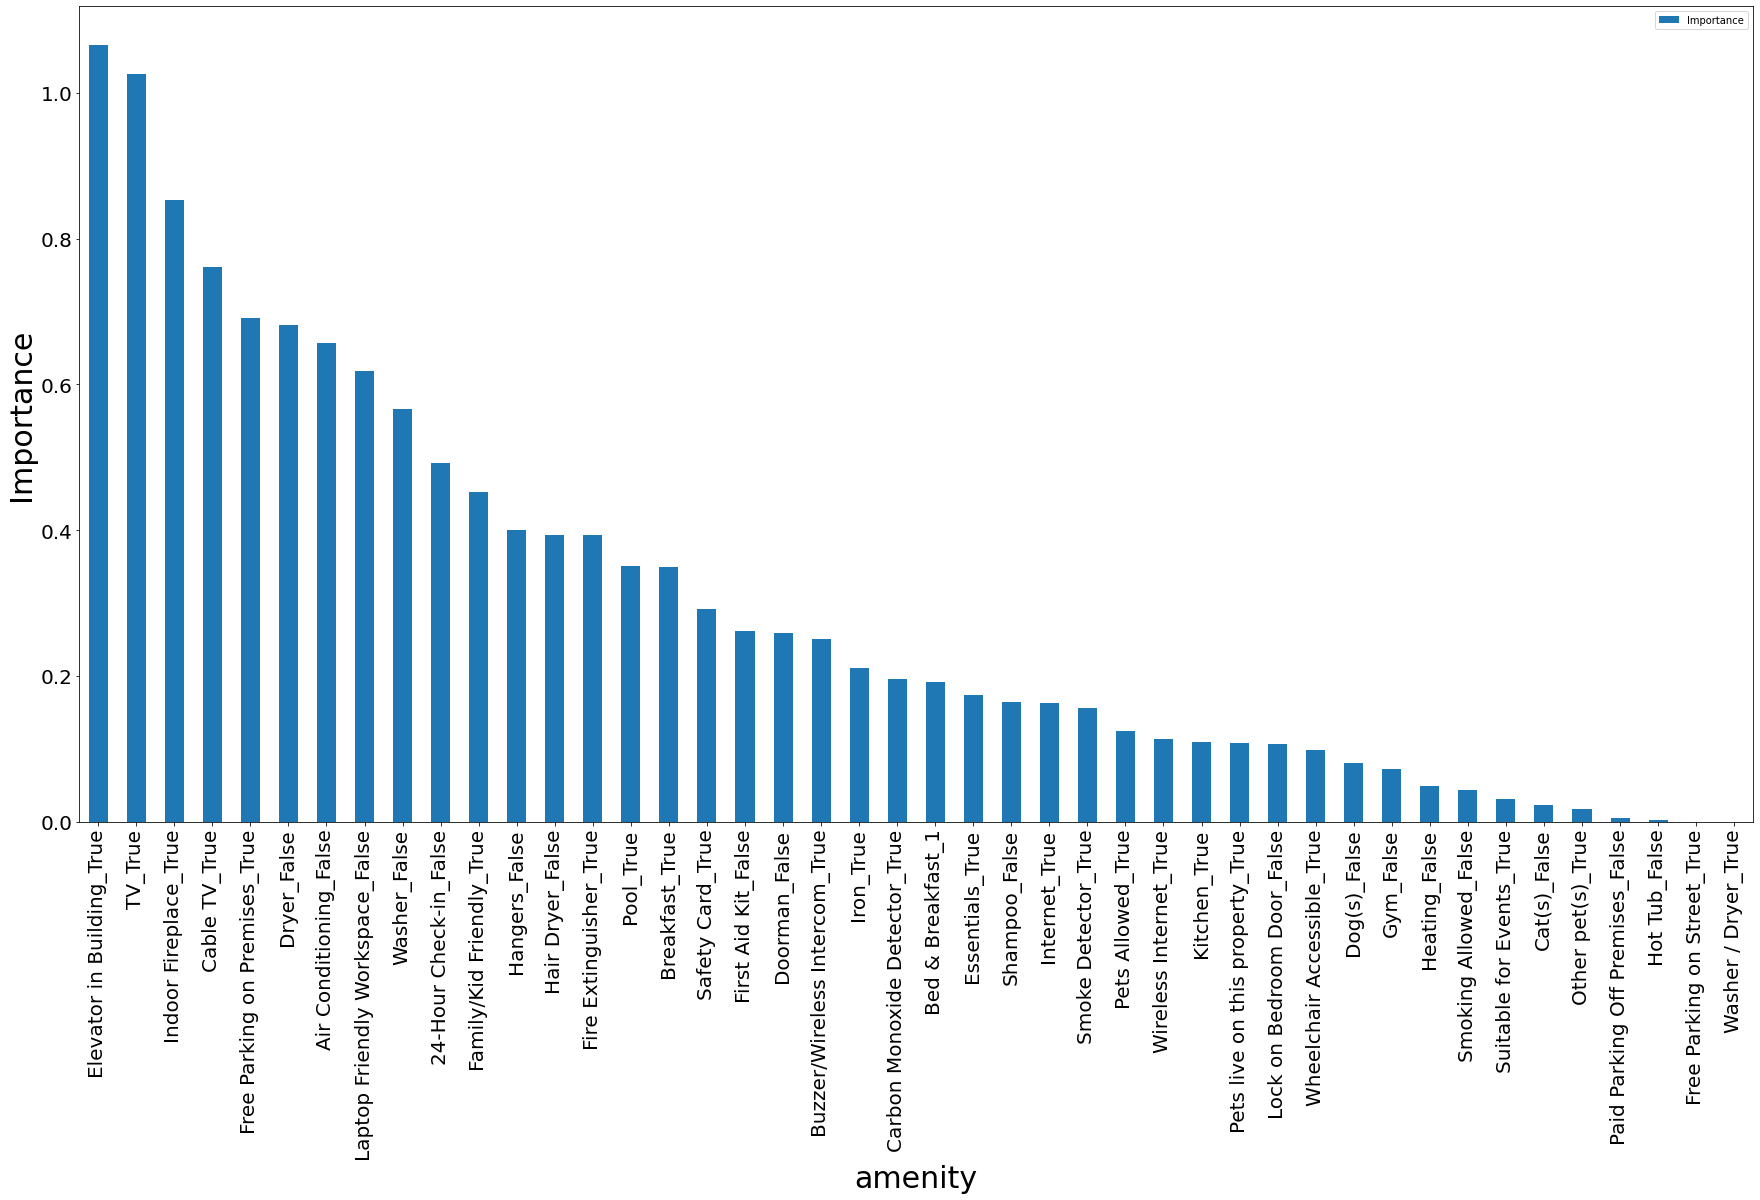

In [151]:
amenity_list = ['24-Hour Check-in', 'Air Conditioning', 'Breakfast',
       'Buzzer/Wireless Intercom', 'Cable TV', 'Carbon Monoxide Detector',
       'Cat(s)', 'Dog(s)', 'Doorman', 'Dryer', 'Elevator in Building',
       'Essentials', 'Family/Kid Friendly', 'Fire Extinguisher',
       'First Aid Kit', 'Free Parking on Premises',
       'Free Parking on Street', 'Gym', 'Hair Dryer', 'Hangers',
       'Heating', 'Hot Tub', 'Indoor Fireplace', 'Internet', 'Iron',
       'Kitchen', 'Laptop Friendly Workspace', 'Lock on Bedroom Door',
       'Other pet(s)', 'Paid Parking Off Premises', 'Pets Allowed',
       'Pets live on this property', 'Pool', 'Safety Card', 'Shampoo',
       'Smoke Detector', 'Smoking Allowed', 'Suitable for Events', 'TV',
       'Washer', 'Washer / Dryer', 'Wheelchair Accessible',
       'Wireless Internet', 'translation missing: en.hosting_amenity_49',
       'translation missing: en.hosting_amenity_50']

amenity_importance = []
for amenity in amenity_list:
    for col in feature_importance_dict.keys():
        if amenity in col:
            amenity_importance.append((col,feature_importance_dict[col]))
        
amenity_importance.sort(key=lambda tup: tup[1], reverse = True) 

pd.DataFrame(amenity_importance, columns = ['amenity','Importance']).drop_duplicates().set_index('amenity').plot(kind='bar', figsize = (30,15))
plt.xticks(fontsize=20)
plt.xlabel('amenity', fontsize=30)
plt.ylabel('Importance', fontsize=30)


The effect of neighborhood on price.

In [204]:
df_original['price'] = df_original['price'].map(lambda p: int(p[1:-3].replace(",", "")))
df_original = df_original.query('price < 500')

In [210]:
n_price = []

for n in neighborhoods:
    n_price.append((n, df_original[df_original['neighbourhood_cleansed'] == n]['price'].mean()))

Text(0, 0.5, 'Average Price')

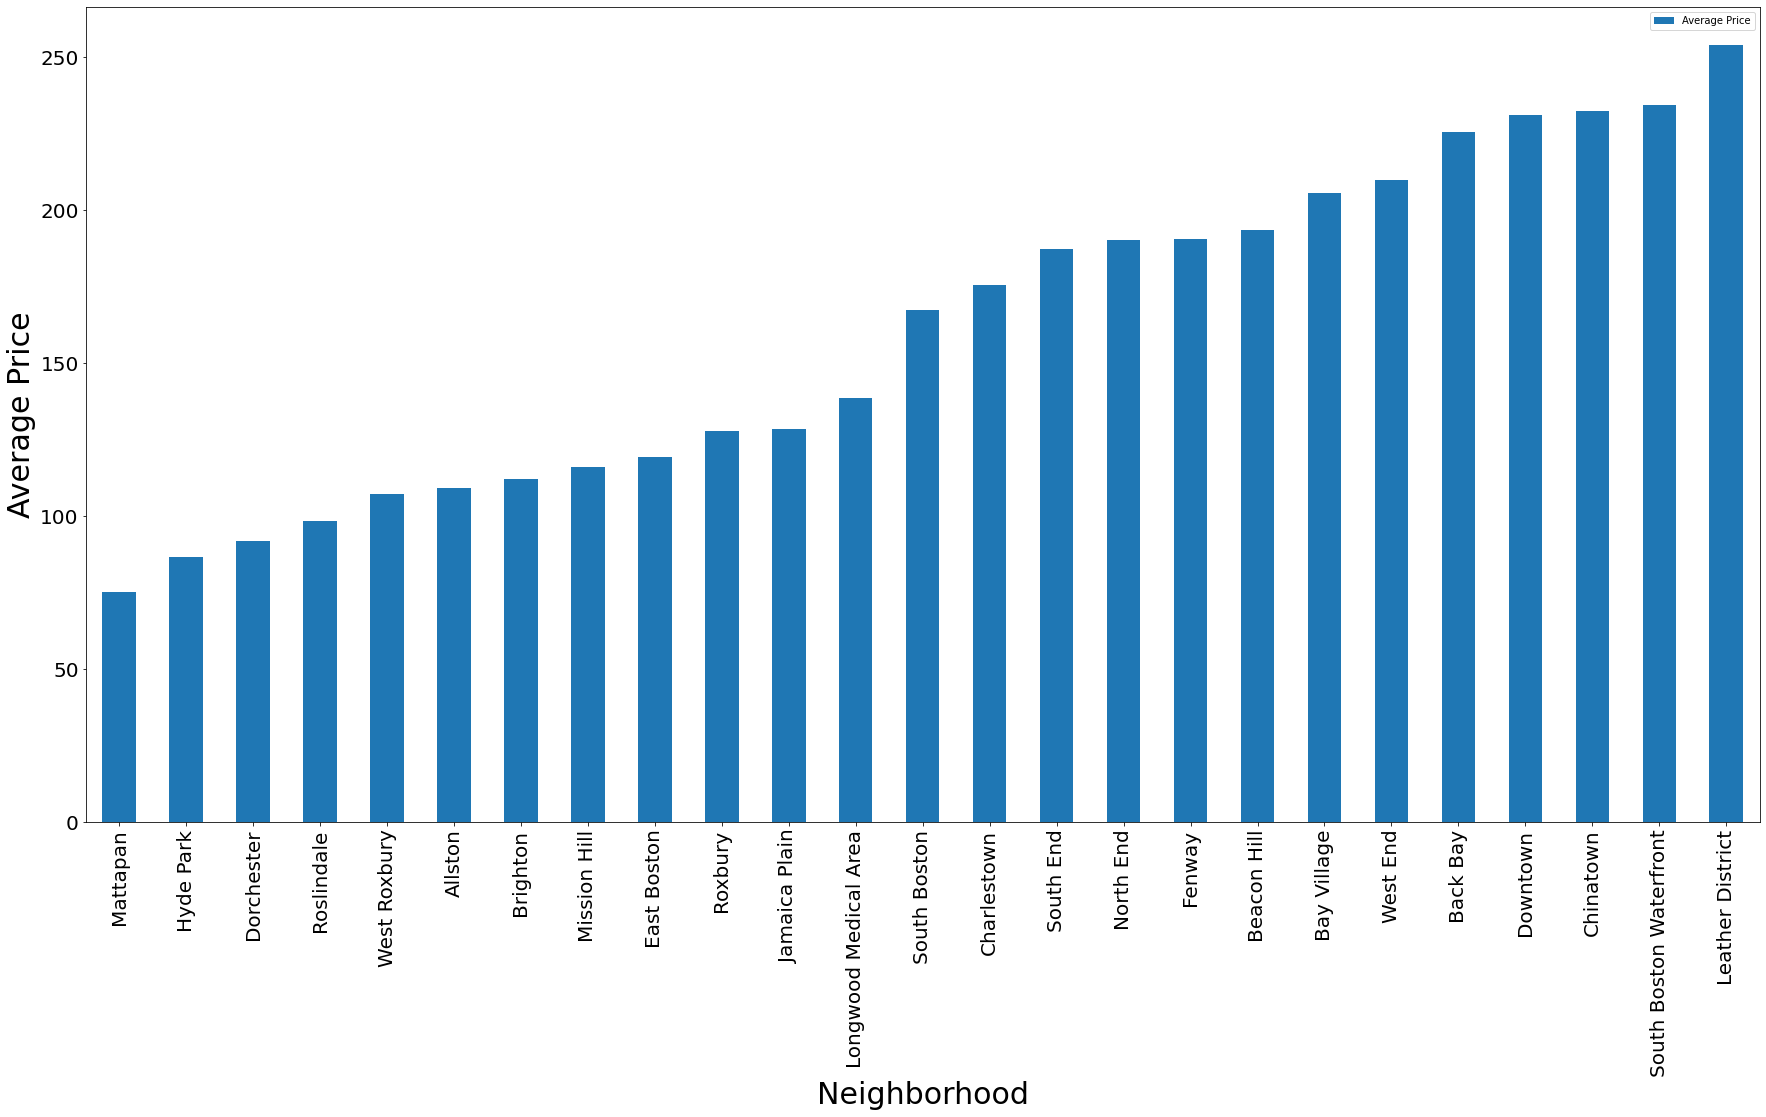

In [217]:
pd.DataFrame(n_price, columns = ['Neighborhood','Average Price']).drop_duplicates().set_index('Neighborhood').sort_values(by = 'Average Price').plot(kind='bar', figsize = (30,15))
plt.xticks(fontsize=20)
plt.xlabel('Neighborhood', fontsize=30)
plt.ylabel('Average Price', fontsize=30)